# Multi-variate TCN

In [ ]:
# you can use "https://colab.research.google.com/drive/17v8a2wHdIbEvUqBwK671VaOYXHOadYpe#scrollTo=TDjKf_9aXvrg" as referance

In [2]:
from darts.datasets import AirPassengersDataset
from darts.explainability.tft_explainer import TFTExplainer
from darts.models import TFTModel
import torch

In [5]:
import pandas as pd

In [11]:
from darts import TimeSeries
import numpy as np
from darts.dataprocessing.transformers import Scaler


In [46]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import matplotlib.pyplot as plt

C:\Users\abood\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------


Epoch 99: 100%|██████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s, train_loss=2.58e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s, train_loss=2.58e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


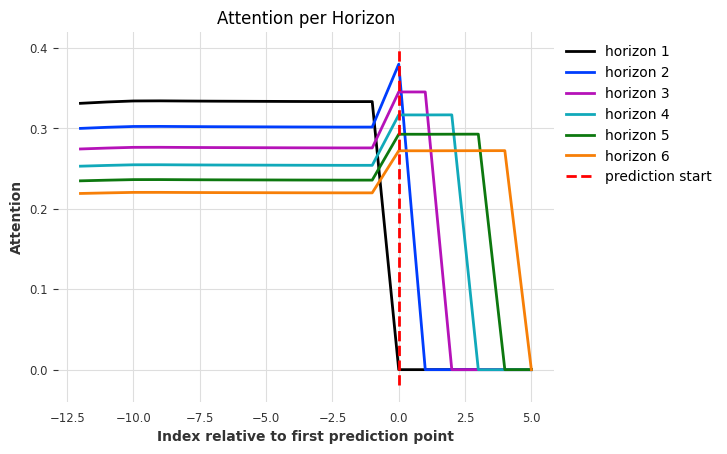

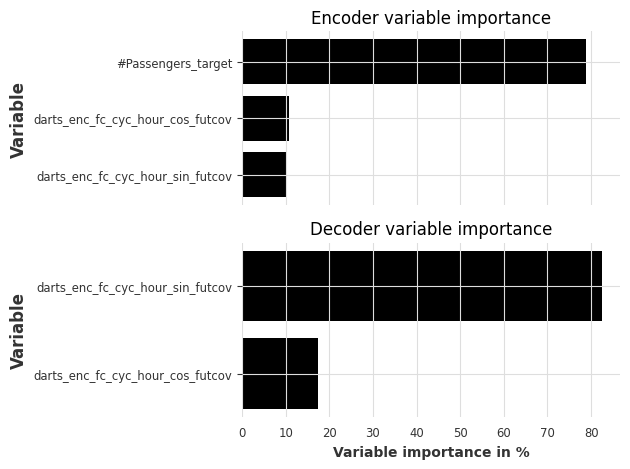

In [1]:
# run this first!


ser = AirPassengersDataset().load()
model = TFTModel(
    input_chunk_length=12,
    output_chunk_length=6,
    add_encoders={"cyclic": {"future": ["hour"]}}
)
model.fit(ser)
# create the explainer and generate explanations
explainer = TFTExplainer(model)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

In [ ]:
model = TCNModel(
    input_chunk_length=24*7,
    output_chunk_length=6,
    kernel_size=6,
    num_filters=32,
    num_layers=4,
    torch_metrics=explained_variance,
    n_epochs=50,
    batch_size=32,
    dropout=0.1,
    dilation_base=2,
    likelihood=None
)

model.fit(train, verbose=True)

# Multi-variate TFT-transformer

In [ ]:
# you can use "https://colab.research.google.com/drive/1WUwDaw3yKl4RN5VPFpc6eDyuuxKX6wj8#scrollTo=Lt2-raEM2Pf-&line=5&uniqifier=1" as referance

In [51]:
df = pd.read_csv("Datasets-with-cloud/amman_Ready.csv")
df.drop(['Cloud Cover %'], axis = 1, inplace = True)

In [52]:
df.set_index("Unnamed: 0", inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [53]:
# Set datetime index if not already done


# Limit to last 7 years
cutoff_start = df.index.max() - pd.DateOffset(years=15)
df_last_15yrs = df[df.index >= cutoff_start]

# Convert to TimeSeries
series = TimeSeries.from_dataframe(df_last_15yrs)
series = series.astype('float32')

In [54]:
time_index = series.time_index
cutoff = time_index[int(len(time_index) * 0.7)]

train_series = series.slice(series.start_time(), cutoff)
val_series = series.slice(cutoff + pd.Timedelta(hours=1), series.end_time())

In [55]:
scaler = Scaler()
train_scaled = scaler.fit_transform(train_series)
val_scaled = scaler.transform(val_series)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.9 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.2 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K  | train
7  | static_cont

Epoch 19: 100%|████████████████████████████████████████████████████| 180/180 [00:49<00:00,  3.67it/s, train_loss=0.290]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|████████████████████████████████████████████████████| 180/180 [00:49<00:00,  3.67it/s, train_loss=0.290]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


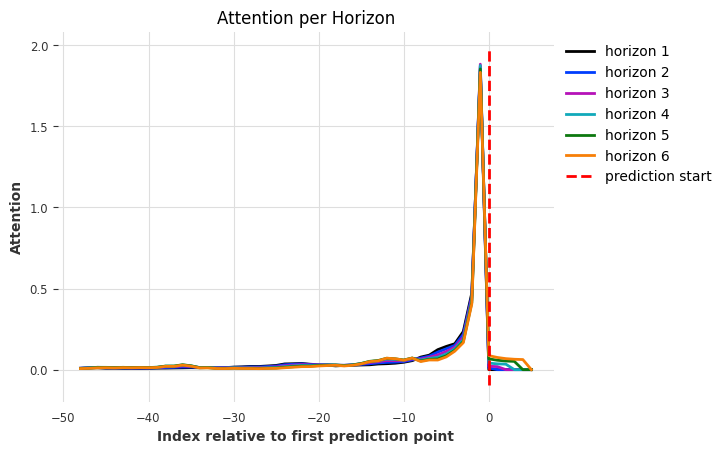

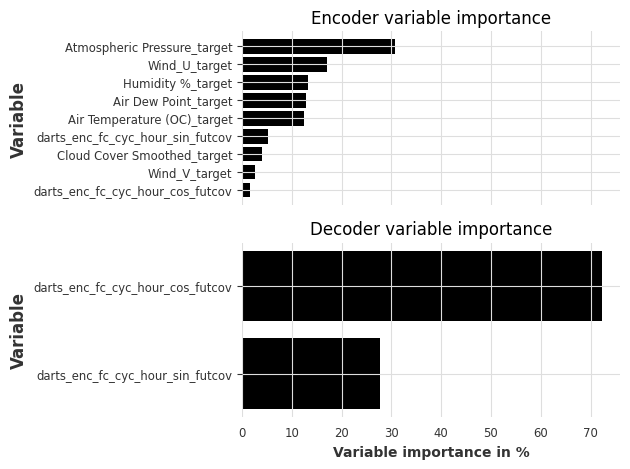

In [56]:
model = TFTModel(
    input_chunk_length=48,
    output_chunk_length=6,
    add_encoders={"cyclic": {"future": ["hour"]}},
    n_epochs=20,
    batch_size=512,  # Increase as high as your GPU can handle (e.g., 256, 512)
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1,
        "precision": "32-true",  # Use mixed precision (saves memory, often faster)
        "enable_progress_bar": True,  # Optional: less console clutter
        "log_every_n_steps": 10,
    }
)

model.fit(train_scaled)

explainer = TFTExplainer(model)
results = explainer.explain()

explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


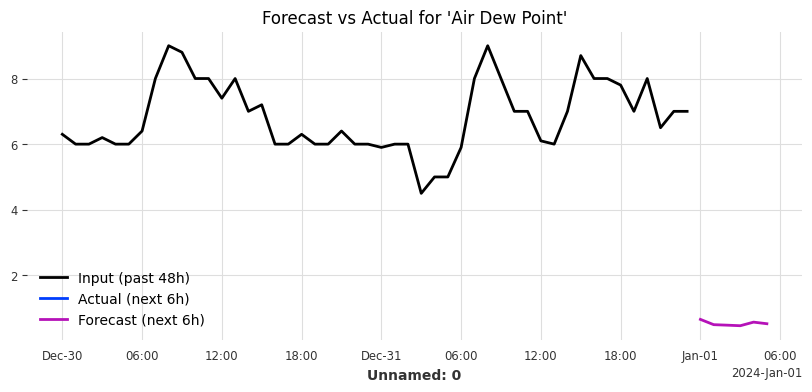

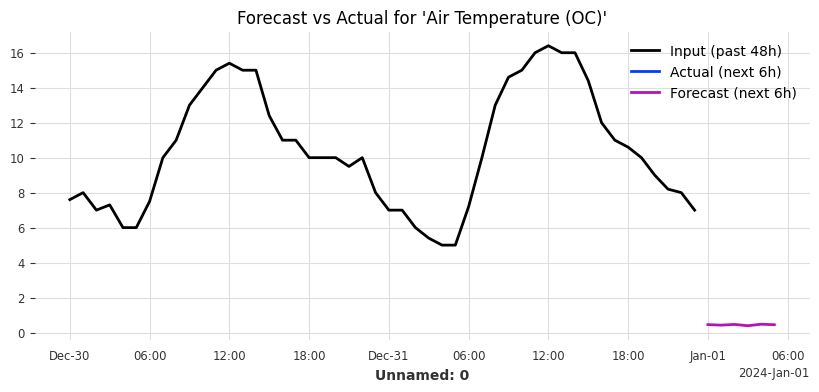

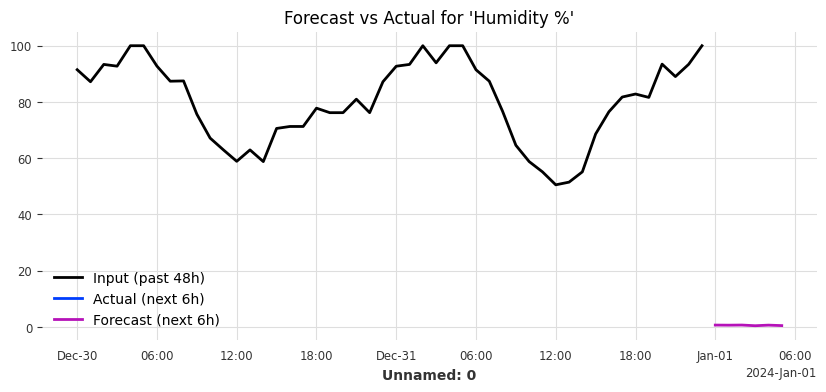

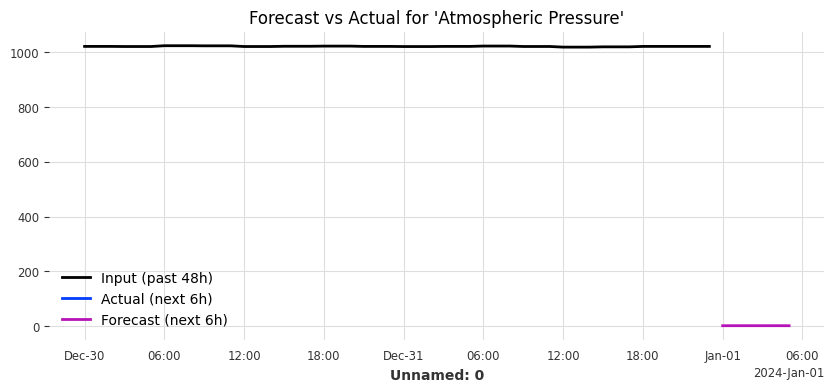

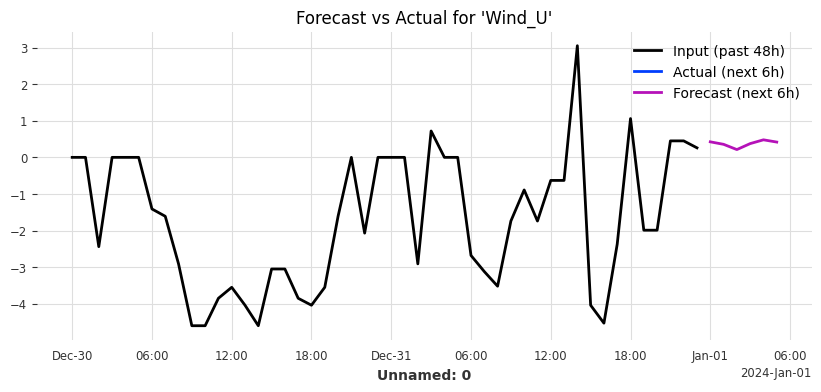

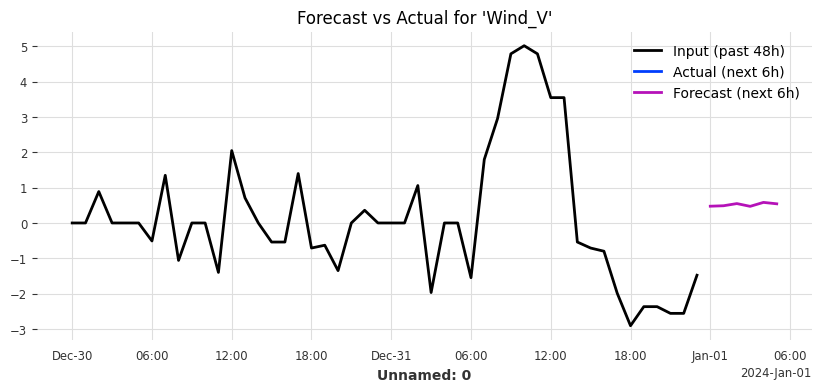

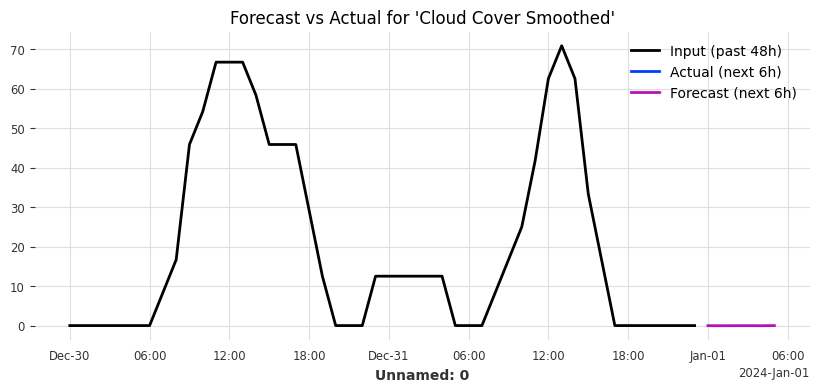

In [57]:
sample_input = val_series[-48:]

# 2. Predict next 6 hours
forecast = model.predict(n=6, series=sample_input)

# 3. Get the actual values for those 6 hours (if available)
actual = val_series.slice(forecast.start_time(), forecast.end_time())

# 4. Plot predicted vs actual for each variable
for component in forecast.components:
    plt.figure(figsize=(10, 4))
    sample_input[component].plot(label="Input (past 48h)", lw=2)
    actual[component].plot(label="Actual (next 6h)", lw=2)
    forecast[component].plot(label="Forecast (next 6h)", lw=2)
    plt.title(f"Forecast vs Actual for '{component}'")
    plt.legend()
    plt.grid(True)
    plt.show()